# **S2MFM-o1: Data-Driven Retail Investing**  
## **Notebook 0: Collection and Initial Exploration**  

**Date:** 5 March 2025  
**Author(s):** Param Moradia, Sophia Z. Boettcher  

---

# **Aggregating Disparate, Sparse Datasets to Better Understand Financial Shocks**  
**Word Count:** [Word Count]  

## **I. Introduction**  

I’ve always been drawn to making sense of disparate, sparse data sources—finding signals in the noise. It started when I was 17 or 19, working on predicting diabetic and seizure events for the U.S. Department of Veterans Affairs out of Hangar One at NASA Ames-Singularity University, Moffett Field.  

That challenge—aligning fragmented, incomplete information to extract real meaning—has stuck with me ever since.  

Recently, my good friend (and brother in spirit), Param, shared a retail investor data visualization with me. Almost immediately, we had the same thought—*what if we built a predictor for the Indian stock market?* Not just any predictor, though. One that makes sense of financial *shocks*—the kind that catch markets off guard and leave investors scrambling.  

We believe that financial shocks don’t emerge from a single source. Instead, they **ripple in from multiple directions**:  

- **Macroeconomic shifts** are slow-moving but fundamental.  
- **Market data** reacts in real-time but lacks broader context.  
- **Sentiment signals** can serve as early warnings but are often noisy.  

The challenge is aligning these **asynchronous signals** in a way that offers **predictive value**. However, defining the **right endpoints**—whether identifying major financial shocks, market downturns, or surges—is **critical** to uncovering meaningful insights from the middle ground.  

---

## **II. Dataset Aggregation: First Pass-Through** 

To construct a robust predictor *(sparse signal mining for financiall markets → S2MFM-o1)*, we begin with three foundational data sources:  

- **Market Data** – Stock prices, indices, and trading volumes to track immediate reactions.  
- **Econimic Indicators** – Interest rates, inflation, and GDP trends to establish macroeconomic context.  
- **Sentiment Signals** – Retail investor search behavior as a potential early indicator of market volatility.
- **Align, clean, and visualize data**
- **Save cleaned dataset for downstream use (e.g., Notebook 1)**

Each of these sources offers **a different lens** on market behavior, but their **true power lies in synthesis**—unifying these fragmented signals to reveal emerging patterns.  

This is just the beginning. The dataset we create here will lay the foundation for everything that follows. If we do this right, we might take a step closer to **predicting the next market shock—before it happens**.

---

## **III. Collect Market Data (Yahoo Finance)**

This section is focused on collecting and preparing financial market data from Yahoo Finance using the `yfinance` library. The goal is to aggregate stock market data from various sources and clean it for further analysis. We want to ensure that **market data aggregation** captures relevant asset classes, including stock indices, cryptocurrency, and volatility measures. The **data cleaning process** standardizes column structures, making the dataset easier to manipulate and analyze. A **fallback mechanism** is implemented to use "Close" prices when "Adj Close" is unavailable, ensuring robustness in case of missing values. With a structured dataset in place, we are now equipped for **further statistical analysis, anomaly detection, and predictive modeling**, setting the foundation for understanding financial shocks.

---

### **1. Get/Reference Packages, Libraries, Dependencies, and APIs**
   - Install and import required libraries (`yfinance`, `pandas`, `numpy`, `fredapi`, `pytrends`, etc.).  
   - Define API keys and set up the data collection environment.  
   - Establish a **time range** (`2000-01-01` to `2025-01-01`) for historical data extraction.  

In [1]:
# run this once if not installed already
# otherwise comment out
# !pip install yfinance fredapi pytrends pandas matplotlib seaborn

In [1]:
# pip install pytrends

In [2]:
# pip install openai==0.28

In [3]:
# pip install requests

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from pytrends.request import TrendReq
from datetime import datetime, timedelta
import time
import openai
import random
import requests
import os

# Set up API keys (Replace with actual API keys if needed)
FRED_API_KEY = "YOUR API KEY HERE"  # your_fred_api_key_here
fred = Fred(api_key=FRED_API_KEY)

# Define the time range
start_date = "2000-01-01"
end_date = "2025-01-01"

### 2. **Fetch Market Data from Yahoo Finance**  
   - Select key financial tickers:  
     - `^GSPC` → **S&P 500 Index** (Broad market benchmark).  
     - `^IXIC` → **NASDAQ Composite** (Tech-heavy index).  
     - `BTC-USD` → **Bitcoin (USD)** (Cryptocurrency market indicator).  
     - `^VIX` → **CBOE Volatility Index (VIX)** (Market sentiment proxy).  
   - Use `yfinance.download()` to retrieve **OHLCV** (Open, High, Low, Close, Volume) data.

In [5]:
# Collect Stock Market Data
tickers = ["^GSPC", "^IXIC", "BTC-USD", "^VIX"]

# FIX: Ensure "Adj Close" column is available
market_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# Print available columns to verify
print("Available columns in market_data:", market_data.columns)

[*********************100%***********************]  4 of 4 completed

Available columns in market_data: MultiIndex([('Adj Close', 'BTC-USD'),
            ('Adj Close',   '^GSPC'),
            ('Adj Close',   '^IXIC'),
            ('Adj Close',    '^VIX'),
            (    'Close', 'BTC-USD'),
            (    'Close',   '^GSPC'),
            (    'Close',   '^IXIC'),
            (    'Close',    '^VIX'),
            (     'High', 'BTC-USD'),
            (     'High',   '^GSPC'),
            (     'High',   '^IXIC'),
            (     'High',    '^VIX'),
            (      'Low', 'BTC-USD'),
            (      'Low',   '^GSPC'),
            (      'Low',   '^IXIC'),
            (      'Low',    '^VIX'),
            (     'Open', 'BTC-USD'),
            (     'Open',   '^GSPC'),
            (     'Open',   '^IXIC'),
            (     'Open',    '^VIX'),
            (   'Volume', 'BTC-USD'),
            (   'Volume',   '^GSPC'),
            (   'Volume',   '^IXIC'),
            (   'Volume',    '^VIX')],
           names=['Price', 'Ticker'])


3. **Data Cleaning and Structuring**  
   - Flatten **MultiIndex columns** for easier handling.  
   - Select **Adjusted Close Prices** as the primary metric for analysis.  
   - Implement **fallback logic** to use "Close" prices if "Adj Close" is unavailable.  
   - Print and inspect the cleaned dataset to ensure consistency.  

In [6]:
# Handle MultiIndex columns if present
if isinstance(market_data.columns, pd.MultiIndex):
    market_data.columns = ['_'.join(col).strip() for col in market_data.columns]  # Flatten MultiIndex

# Print updated column names after flattening
print("Updated market_data columns:", market_data.columns)

# Select 'Adj Close' if available, otherwise use 'Close'
adj_close_cols = [col for col in market_data.columns if "Adj Close" in col]
close_cols = [col for col in market_data.columns if "Close" in col]

if adj_close_cols:
    market_data = market_data[adj_close_cols]
else:
    print("Warning: 'Adj Close' not found, using 'Close' instead.")
    market_data = market_data[close_cols]

# Print final dataset preview
print("Final dataset preview:")
print(market_data.head())

Updated market_data columns: Index(['Adj Close_BTC-USD', 'Adj Close_^GSPC', 'Adj Close_^IXIC',
       'Adj Close_^VIX', 'Close_BTC-USD', 'Close_^GSPC', 'Close_^IXIC',
       'Close_^VIX', 'High_BTC-USD', 'High_^GSPC', 'High_^IXIC', 'High_^VIX',
       'Low_BTC-USD', 'Low_^GSPC', 'Low_^IXIC', 'Low_^VIX', 'Open_BTC-USD',
       'Open_^GSPC', 'Open_^IXIC', 'Open_^VIX', 'Volume_BTC-USD',
       'Volume_^GSPC', 'Volume_^IXIC', 'Volume_^VIX'],
      dtype='object')
Final dataset preview:
            Adj Close_BTC-USD  Adj Close_^GSPC  Adj Close_^IXIC  \
Date                                                              
2000-01-03                NaN      1455.219971      4131.149902   
2000-01-04                NaN      1399.420044      3901.689941   
2000-01-05                NaN      1402.109985      3877.540039   
2000-01-06                NaN      1403.449951      3727.129883   
2000-01-07                NaN      1441.469971      3882.620117   

            Adj Close_^VIX  
Date          

## **IV. Collect Economic Indicators (FRED)**

This section focuses on aggregating key economic indicators from the **Federal Reserve Economic Data (FRED)** database. These macroeconomic factors provide **fundamental insights** into economic health, which, when combined with market and sentiment data, can enhance our ability to detect financial shocks.  

The dataset includes **interest rates, inflation, unemployment, consumer sentiment, and GDP**, among others. Additionally, we apply **lagged features and rolling averages** to capture historical trends and provide deeper temporal insights.

---

### **1. Define & Fetch Key Economic Indicators**  

We retrieve the following FRED series:  

- **Bond Yields (DGS10)** → 10-year U.S. Treasury Yield (market risk appetite).  
- **Inflation (CPIAUCSL)** → Consumer Price Index (cost of living trends).  
- **Unemployment (UNRATE)** → U.S. unemployment rate (labor market health).  
- **Interest Rates (FEDFUNDS)** → Federal Funds Rate (monetary policy).  
- **Consumer Sentiment (UMCSENT)** → University of Michigan Consumer Sentiment Index.  
- **Gross Domestic Product (GDP)** → U.S. economic growth indicator.  

Each of these variables plays a role in shaping **market conditions, investor confidence, and economic policy responses**.

In [7]:
# Collect Economic Indicators from FRED
bond_yields = fred.get_series("DGS10", start_date, end_date)  # 10-year Treasury Yield
inflation = fred.get_series("CPIAUCSL", start_date, end_date)  # Consumer Price Index
unemployment = fred.get_series("UNRATE", start_date, end_date)  # Unemployment Rate

# Convert to DataFrame
econ_data = pd.DataFrame({"Bond Yields": bond_yields, "Inflation": inflation, "Unemployment": unemployment})

# Define FRED series IDs for key economic indicators
fred_series = {
    "Bond Yields": "DGS10",        # 10-year Treasury Yield
    "Inflation": "CPIAUCSL",        # Consumer Price Index
    "Unemployment": "UNRATE",       # Unemployment Rate
    "Interest Rate": "FEDFUNDS",    # Federal Funds Rate
    "Consumer Sentiment": "UMCSENT", # University of Michigan Consumer Sentiment Index
    "GDP": "GDP",                   # Gross Domestic Product (quarterly)
}

# Fetch data from FRED
econ_data = {name: fred.get_series(series, start_date, end_date) for name, series in fred_series.items()}

# Convert to DataFrame and set Date index
econ_data = pd.DataFrame(econ_data)
econ_data.index = pd.to_datetime(econ_data.index)

# Fill missing values using forward-fill
econ_data.fillna(method="ffill", inplace=True)

### **2. Feature Engineering: Lagging & Rolling Indicators**

We hope to integrate **fundamental economic indicators** to enrich market analysis. By incorporating interest rates, inflation, unemployment, and consumer sentiment, we introduce macroeconomic context to our financial shock prediction framework. Feature engineering through **lagged variables and rolling averages** helps capture **long-term trends and delayed economic effects**.

To enhance predictive power, we generate **lagging features** and **rolling averages** to capture historical trends:
- **Lagging Features** → 1-month, 3-month, and 6-month lags to observe **delayed economic effects**.
- **Rolling Averages** → 3-month and 6-month rolling windows to **smooth fluctuations** and identify sustained trends.

In [8]:
# Add Lagging Features (1-month, 3-month, 6-month lag)
lag_periods = [30, 90, 180]  # Days
for lag in lag_periods:
    for col in econ_data.columns:
        econ_data[f"{col}_lag{lag}"] = econ_data[col].shift(lag)

# Add Rolling Averages (3-month and 6-month)
rolling_windows = [90, 180]  # Days
for window in rolling_windows:
    for col in econ_data.columns:
        econ_data[f"{col}_rolling{window}"] = econ_data[col].rolling(window).mean()

# Print summary
print("Economic Data with Lagging Features:")
print(econ_data.head())

Economic Data with Lagging Features:
            Bond Yields  Inflation  Unemployment  Interest Rate  \
2000-01-01          NaN      169.3           4.0           5.45   
2000-01-03         6.58      169.3           4.0           5.45   
2000-01-04         6.49      169.3           4.0           5.45   
2000-01-05         6.62      169.3           4.0           5.45   
2000-01-06         6.57      169.3           4.0           5.45   

            Consumer Sentiment        GDP  Bond Yields_lag30  Inflation_lag30  \
2000-01-01               112.0  10002.179                NaN              NaN   
2000-01-03               112.0  10002.179                NaN              NaN   
2000-01-04               112.0  10002.179                NaN              NaN   
2000-01-05               112.0  10002.179                NaN              NaN   
2000-01-06               112.0  10002.179                NaN              NaN   

            Unemployment_lag30  Interest Rate_lag30  ...  \
2000-01-01   

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_21910/2006092059.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  econ_data[f"{col}_rolling{window}"] = econ_data[col].rolling(window).mean()
/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_21910/2006092059.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  econ_data[f"{col}_rolling{window}"] = econ_data[col].rolling(window).mean()
/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_21910/2006092059.py:11: PerformanceWarning: DataFrame is highly f

### **3. Merging with Market Data & Handling Missing Values**

To **align economic indicators** with stock market data, we merge `econ_data` with `market_data` on **date index**, ensuring a **comprehensive dataset** for modeling. Merging these indicators with market data ensures a holistic dataset, setting the stage for multi-factor predictive modeling.

In [9]:
# Align and Merge Datasets
econ_data.index = pd.to_datetime(econ_data.index)
market_data.index = pd.to_datetime(market_data.index)
full_data = market_data.merge(econ_data, left_index=True, right_index=True, how="outer")

# Handle missing values
full_data.fillna(method="ffill", inplace=True)

In [10]:
# # Compute Rolling Standard Deviation (Volatility Measure)
# full_data["Rolling_Std_30d"] = full_data["^GSPC"].rolling(window=30).std()

# Compute Rolling Standard Deviation (Volatility Measure)
rolling_std_30d = full_data["Adj Close_^GSPC"].rolling(window=30).std()

# Use pd.concat() to efficiently add it to full_data
full_data = pd.concat([full_data, rolling_std_30d.rename("Rolling_Std_30d")], axis=1)

# Print confirmation
print("Rolling 30-Day Standard Deviation added successfully.")

Rolling 30-Day Standard Deviation added successfully.


## **V. Extract Sentiment Signals (Google Trends)**

Market sentiment plays a **critical role** in financial shocks, as investor behavior is often influenced by news cycles, speculation, and macroeconomic trends. To quantify sentiment shifts, we collect data from **Google Trends** and attempt to extract insights from **ChatGPT query volume**.  

This section focuses on:  
- **Google Trends Data** → Search interest for key financial terms (e.g., "market crash", "buy gold", "recession").  

By integrating these sentiment signals with **market and macroeconomic data**, we aim to **detect early warning signs of financial shocks**.

---

### **1. Collect Sentiment Data from Google Trends**  

Google Trends provides a **relative search interest score (0-100)**, where 100 represents peak popularity for a search term. We track **financial anxiety-related keywords** to assess sentiment shifts. *Note that this section might benefit on a second pass-through from extracting affinity notes patterns to inform keyword selection via interview-based qualitative inquiry.* Essentially, right now we are speculating what people might search for when worried about the "state of the economy."

#### **Selected Google Trends Search Terms:**  
- `"market crash"` → Detects fear-driven investor behavior.  
- `"buy gold"` → Measures demand for safe-haven assets.  
- `"recession"` → Gauges economic pessimism.  
- `"inflation"` → Tracks public concern over rising costs.  
- `"stock market crash"` → Indicates retail investor panic.  
- `"interest rates"` → Monitors rate hike fears.  

#### **Fetching Data Using Pytrends**
We use the **Pytrends API** to collect search interest data for the past five years. To avoid rate limits (HTTP 429 error) when using Google Trends API, you can batch process search terms two at a time in our query logic. Note that when we want a long timespan view of Google Trends, it will return monthly snapshots. To handle the null values that would occur when we integrate with the primary table, we choose to forward-fill impute.

In [12]:
# Define search terms
search_terms = ["market crash", "buy gold", "recession", "inflation", "stock market crash", "interest rates"]
# search_terms = ["market crash", "buy gold"]

# Set up Pytrends with a User-Agent header to reduce blocking
pytrends = TrendReq(hl='en-US', tz=360, retries=5, backoff_factor=2)

# Function to Fetch Google Trends Data in Batches of 2 with Rate Limit Handling
def fetch_google_trends(search_terms, timeframe="all", delay=60): # default:timeframe="today 5-y"
    all_trends = []
    batch_size = 2  # Fetch 2 keywords at a time

    for i in range(0, len(search_terms), batch_size):
        batch = search_terms[i:i + batch_size]
        print(f"Fetching Google Trends data for: {batch}")

        try:
            pytrends.build_payload(batch, timeframe=timeframe)
            trends_chunk = pytrends.interest_over_time().drop(columns=["isPartial"], errors="ignore")
            
            if not trends_chunk.empty:
                all_trends.append(trends_chunk)

            time.sleep(delay)  # Increase delay to avoid being blocked

        except Exception as e:
            print(f"Error fetching data for {batch}: {e}")
            time.sleep(90)  # If blocked, wait longer before retrying

    return pd.concat(all_trends, axis=1).sort_index() if all_trends else pd.DataFrame()

# Fetch Google Trends Data
# comment out when debugging to prevent punishment from over-pinging
# trends_data = fetch_google_trends(search_terms, delay=60)

# Print sample of Google Trends data
print("Google Trends Data Sample:")
print(trends_data.head())

Fetching Google Trends data for: ['market crash', 'buy gold']
Fetching Google Trends data for: ['recession', 'inflation']
Fetching Google Trends data for: ['stock market crash', 'interest rates']
Google Trends Data Sample:
            market crash  buy gold  recession  inflation  stock market crash  \
date                                                                           
2004-01-01            31        28          4         49                   7   
2004-02-01            36        23          4         45                   8   
2004-03-01            39        22          4         49                   9   
2004-04-01            40        22          5         50                   9   
2004-05-01            35        22          4         47                   7   

            interest rates  
date                        
2004-01-01              61  
2004-02-01              62  
2004-03-01              69  
2004-04-01              72  
2004-05-01              68  


In [13]:
print("Google Trends Data Sample:")
print(trends_data.head())  # Check if data was returned

Google Trends Data Sample:
            market crash  buy gold  recession  inflation  stock market crash  \
date                                                                           
2004-01-01            31        28          4         49                   7   
2004-02-01            36        23          4         45                   8   
2004-03-01            39        22          4         49                   9   
2004-04-01            40        22          5         50                   9   
2004-05-01            35        22          4         47                   7   

            interest rates  
date                        
2004-01-01              61  
2004-02-01              62  
2004-03-01              69  
2004-04-01              72  
2004-05-01              68  


In [14]:
print("Google Trends Data Frequency Check:")
print(trends_data.index.to_series().diff().value_counts())

Google Trends Data Frequency Check:
date
31 days    148
30 days     84
28 days     16
29 days      6
Name: count, dtype: int64


In [15]:
full_data.head()

,Adj Close_BTC-USD,Adj Close_^GSPC,Adj Close_^IXIC,Adj Close_^VIX,Bond Yields,Inflation,Unemployment,Interest Rate,Consumer Sentiment,GDP,...,Interest Rate_lag90_lag180_rolling90_rolling180,Consumer Sentiment_lag90_lag180_rolling90_rolling180,GDP_lag90_lag180_rolling90_rolling180,Bond Yields_lag30_lag90_lag180_rolling90_rolling180,Inflation_lag30_lag90_lag180_rolling90_rolling180,Unemployment_lag30_lag90_lag180_rolling90_rolling180,Interest Rate_lag30_lag90_lag180_rolling90_rolling180,Consumer Sentiment_lag30_lag90_lag180_rolling90_rolling180,GDP_lag30_lag90_lag180_rolling90_rolling180,Rolling_Std_30d
2000-01-01,NaN,NaN,NaN,NaN,NaN,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,NaN,1455.219971,4131.149902,24.209999,6.58,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,1399.420044,3901.689941,27.010000,6.49,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,1402.109985,3877.540039,26.410000,6.62,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,1403.449951,3727.129883,25.730000,6.57,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. **Forward-Fill Imputation of Google Trends Data**

Since Google Trends data is **only available for specific months**, merging it with **daily or weekly market data** will create **gaps (NaNs) for missing days**. The best way to **handle missing values** is through **forward-fill imputation** (`ffill()`), ensuring that sentiment data **persists until the next available data point**.

In [16]:
# Initialize empty DataFrames to prevent overriding
trends_dataTest = trends_data.copy()

In [17]:
trends_dataTest.head()

,market crash,buy gold,recession,inflation,stock market crash,interest rates
date,,,,,,
2004-01-01,31,28,4,49,7,61
2004-02-01,36,23,4,45,8,62
2004-03-01,39,22,4,49,9,69
2004-04-01,40,22,5,50,9,72
2004-05-01,35,22,4,47,7,68


In [18]:
full_dataTest = full_data.copy()

In [19]:
full_dataTest.head()

,Adj Close_BTC-USD,Adj Close_^GSPC,Adj Close_^IXIC,Adj Close_^VIX,Bond Yields,Inflation,Unemployment,Interest Rate,Consumer Sentiment,GDP,...,Interest Rate_lag90_lag180_rolling90_rolling180,Consumer Sentiment_lag90_lag180_rolling90_rolling180,GDP_lag90_lag180_rolling90_rolling180,Bond Yields_lag30_lag90_lag180_rolling90_rolling180,Inflation_lag30_lag90_lag180_rolling90_rolling180,Unemployment_lag30_lag90_lag180_rolling90_rolling180,Interest Rate_lag30_lag90_lag180_rolling90_rolling180,Consumer Sentiment_lag30_lag90_lag180_rolling90_rolling180,GDP_lag30_lag90_lag180_rolling90_rolling180,Rolling_Std_30d
2000-01-01,NaN,NaN,NaN,NaN,NaN,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,NaN,1455.219971,4131.149902,24.209999,6.58,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,1399.420044,3901.689941,27.010000,6.49,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,1402.109985,3877.540039,26.410000,6.62,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,1403.449951,3727.129883,25.730000,6.57,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **VI. Data Sanitization and Initial Visualizations**

Before conducting exploratory data analysis (EDA) or training models, we must ensure that our dataset is **properly structured, free from missing values, and aligned across all sources.** We want to ensure **clean, consistent, and structured data** for further analysis. A well-prepared dataset improves the reliability of our **financial shock predictions** and **market sentiment modeling.** This section performs **data sanitization** by:
- **Aligning** financial market data and sentiment data (Google Trends).
- **Resampling** the dataset to a **daily frequency** to maintain uniform time intervals.
- **Handling missing values** with **forward-fill imputation** (`ffill()`), ensuring continuity in time-series data.
- **Removing duplicate columns** to prevent redundancy after merging multiple datasets.

---

### **1. Google Trends Data Sanitization**
  **A) Ensure Google Trends data contains all search terms**  
   - Reindex `trends_dataTest` to include all expected search terms (e.g., "market crash", "inflation").
   - Fill missing terms with `0` to ensure consistency.

  **B) Convert timestamps and resample data to daily frequency**  
   - Convert the index to **datetime format** for consistency.
   - Resample `trends_dataTest` to daily granularity and apply **forward-fill imputation** (`ffill()`) to propagate the last known values.

  **C) Merge with `full_dataTest`**  
   - Ensure `full_dataTest` and `trends_dataTest` share the same **datetime index**.
   - Merge **Google Trends sentiment data** with the main dataset (`full_dataTest`).

  **D) Handle missing values and duplicates**  
   - Use **`ffill()`** to fill missing sentiment values forward in time.
   - Remove **duplicate columns** that might arise from merging multiple datasets.

  **E) Final Dataset Checks**  
   - Print **dataset dimensions** (`shape`) to confirm all expected data is present.
   - List **all column names** to verify successful integration.
   - Display **a subset of 2004 data** to confirm trends data has been properly merged.

In [20]:
# ✅ Ensure Google Trends data contains all required columns
if not trends_dataTest.empty:
    # Ensure all search terms are in the dataset
    trends_dataTest = trends_dataTest.reindex(columns=search_terms, fill_value=0)

    # ✅ Convert to datetime before resampling
    trends_dataTest.index = pd.to_datetime(trends_dataTest.index)
    trends_dataTest = trends_dataTest.resample('D').ffill()  # Convert to daily, forward-fill missing values

    # ✅ Ensure both datasets have datetime index
    full_dataTest.index = pd.to_datetime(full_dataTest.index)

    # ✅ Merge full_dataTest with Google Trends data
    full_dataTest = full_dataTest.merge(trends_dataTest, left_index=True, right_index=True, how="left")

    # ✅ Forward-fill missing values after merging
    full_dataTest.fillna(method="ffill", inplace=True)

    # ✅ Remove duplicate columns
    full_dataTest = full_dataTest.loc[:, ~full_dataTest.columns.duplicated()]

    print("✅ Google Trends data successfully integrated!")
    
    # ✅ Dataset checks
    print("Full dataset shape:", full_dataTest.shape)
    print("Columns in full_dataTest:", full_dataTest.columns.tolist())
    
    # ✅ Verify 2004 data integration
    print(full_dataTest.loc["2004", search_terms].head())

else:
    print("❌ Google Trends data could not be retrieved.")

✅ Google Trends data successfully integrated!
Full dataset shape: (7649, 203)
Columns in full_dataTest: ['Adj Close_BTC-USD', 'Adj Close_^GSPC', 'Adj Close_^IXIC', 'Adj Close_^VIX', 'Bond Yields', 'Inflation', 'Unemployment', 'Interest Rate', 'Consumer Sentiment', 'GDP', 'Bond Yields_lag30', 'Inflation_lag30', 'Unemployment_lag30', 'Interest Rate_lag30', 'Consumer Sentiment_lag30', 'GDP_lag30', 'Bond Yields_lag90', 'Inflation_lag90', 'Unemployment_lag90', 'Interest Rate_lag90', 'Consumer Sentiment_lag90', 'GDP_lag90', 'Bond Yields_lag30_lag90', 'Inflation_lag30_lag90', 'Unemployment_lag30_lag90', 'Interest Rate_lag30_lag90', 'Consumer Sentiment_lag30_lag90', 'GDP_lag30_lag90', 'Bond Yields_lag180', 'Inflation_lag180', 'Unemployment_lag180', 'Interest Rate_lag180', 'Consumer Sentiment_lag180', 'GDP_lag180', 'Bond Yields_lag30_lag180', 'Inflation_lag30_lag180', 'Unemployment_lag30_lag180', 'Interest Rate_lag30_lag180', 'Consumer Sentiment_lag30_lag180', 'GDP_lag30_lag180', 'Bond Yields_l

In [45]:
# debugging print statements
# print(full_dataTest.loc["2004", search_terms].head())

In [46]:
# full_dataTest.loc["2004"].tail()

### **2. Debugging Caution**
- **Forward-fill imputation (`ffill()`) should be verified before running permanently.**  
- Debugging print statements can be **commented out** once data integrity is confirmed.
- **`full_dataTest.copy()` ensures we don't overwrite `full_data` while testing.**  

In [21]:
### CAUTION!! ###
# only run once we verified forward-fill imputation is working
# while debugging, keep commented out
# full_data = full_dataTest.copy()

In [86]:
# full_data.head()

### **3. Visualizing Trends**
Once the dataset is sanitized, we proceed to **initial visualizations** to:
- Identify **patterns and anomalies** in financial indicators and sentiment data.  
- Check for **spikes in search trends** that correlate with **market volatility**.  
- Validate that **data alignment is correct** across all sources.

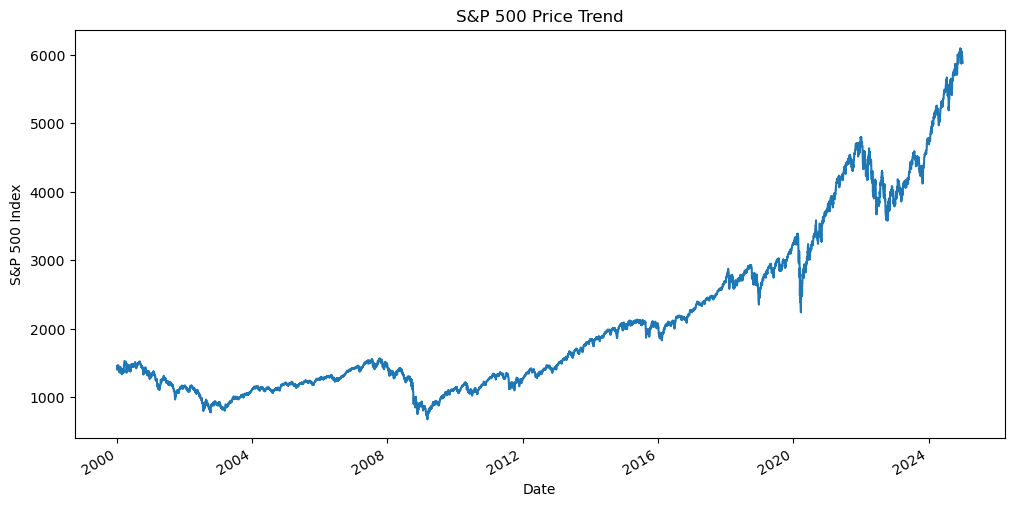

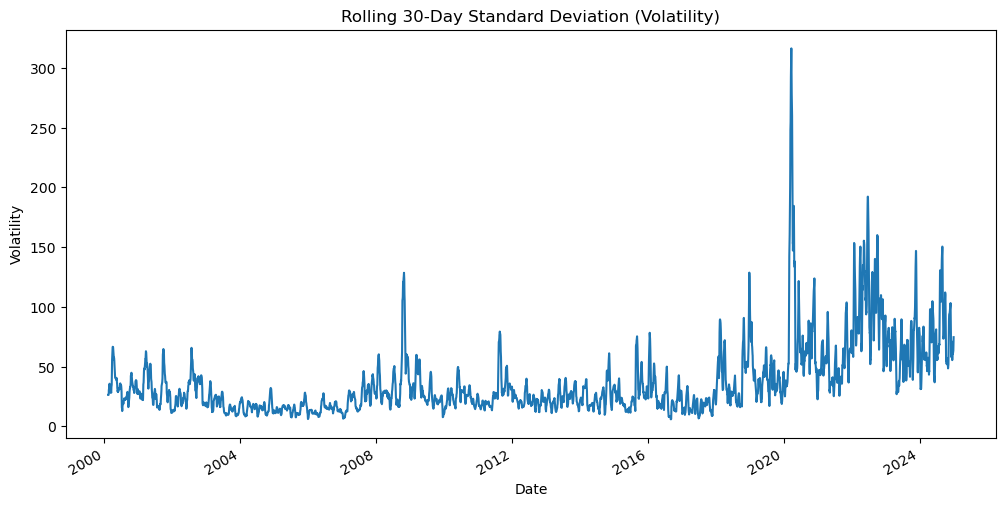

In [22]:
# Visualizations
plt.figure(figsize=(12, 6))
full_data["Adj Close_^GSPC"].plot(title="S&P 500 Price Trend", ylabel="S&P 500 Index", xlabel="Date")
plt.show()

plt.figure(figsize=(12, 6))
full_data["Rolling_Std_30d"].plot(title="Rolling 30-Day Standard Deviation (Volatility)", ylabel="Volatility", xlabel="Date")
plt.show()

# plt.figure(figsize=(10, 6))
# sns.heatmap(full_data.corr(), annot=True, cmap="coolwarm")
# plt.title("Correlation Matrix of Market & Economic Indicators")
# plt.show()

In [23]:
print("Available columns in full_data:")
print(full_data.columns.tolist())  # Show all columns for debugging

Available columns in full_data:
['Adj Close_BTC-USD', 'Adj Close_^GSPC', 'Adj Close_^IXIC', 'Adj Close_^VIX', 'Bond Yields', 'Inflation', 'Unemployment', 'Interest Rate', 'Consumer Sentiment', 'GDP', 'Bond Yields_lag30', 'Inflation_lag30', 'Unemployment_lag30', 'Interest Rate_lag30', 'Consumer Sentiment_lag30', 'GDP_lag30', 'Bond Yields_lag90', 'Inflation_lag90', 'Unemployment_lag90', 'Interest Rate_lag90', 'Consumer Sentiment_lag90', 'GDP_lag90', 'Bond Yields_lag30_lag90', 'Inflation_lag30_lag90', 'Unemployment_lag30_lag90', 'Interest Rate_lag30_lag90', 'Consumer Sentiment_lag30_lag90', 'GDP_lag30_lag90', 'Bond Yields_lag180', 'Inflation_lag180', 'Unemployment_lag180', 'Interest Rate_lag180', 'Consumer Sentiment_lag180', 'GDP_lag180', 'Bond Yields_lag30_lag180', 'Inflation_lag30_lag180', 'Unemployment_lag30_lag180', 'Interest Rate_lag30_lag180', 'Consumer Sentiment_lag30_lag180', 'GDP_lag30_lag180', 'Bond Yields_lag90_lag180', 'Inflation_lag90_lag180', 'Unemployment_lag90_lag180', 'In

In [89]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # ✅ Dynamically find relevant numerical features
# all_features = list(full_data.select_dtypes(include=[np.number]).columns)

# # ✅ Exclude irrelevant features (Adjust as needed)
# exclude_features = ["Rolling_Std_30d"]  # Exclude rolling std if too noisy
# selected_features = [col for col in all_features if col not in exclude_features]

# # ✅ Check if any features are missing
# missing_features = [col for col in selected_features if col not in full_data.columns]
# if missing_features:
#     print(f"⚠️ Warning: The following features are missing from full_data: {missing_features}")

# # ✅ Filter dataset with only available features
# viz_data = full_data[selected_features].dropna()

# # ✅ Handle Scaling (Normalize Data for Better Visualization)
# viz_data = (viz_data - viz_data.mean()) / viz_data.std()

# # ✅ Compute correlation matrix
# corr_matrix = viz_data.corr()

# # ✅ Plot Improved Heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(
#     corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
#     linewidths=0.5, mask=np.triu(np.ones_like(corr_matrix, dtype=bool))
# )
# plt.title("Correlation Matrix of Market & Selected Economic Indicators")
# plt.xticks(rotation=45, ha="right")
# plt.yticks(rotation=0)
# plt.show()

In [24]:
selected_features = [
    "Adj Close_^GSPC", "Adj Close_^IXIC", "Adj Close_BTC-USD", "Adj Close_^VIX",
    "Bond Yields", "Inflation", "Unemployment", "Interest Rate",
    "market crash", "buy gold", "recession", "inflation"
]

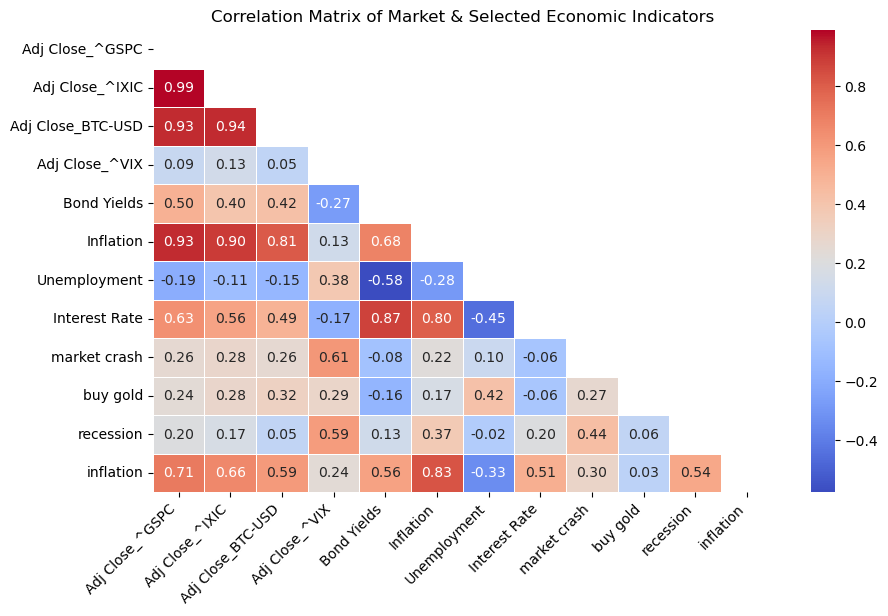

In [25]:
# ✅ 1. Dynamically Select Key Features
all_features = list(full_data.select_dtypes(include=[np.number]).columns)

# ✅ 2. Exclude Excessive Lagging & Rolling Features (Keep Only One Lag per Variable)
exclude_keywords = ["lag90", "lag180", "rolling90", "rolling180"]  # Reduce duplicate lag features
selected_features = [col for col in all_features if not any(keyword in col for keyword in exclude_keywords)]

# ✅ 3. Prioritize Essential Features (Stock Prices, Macroeconomic Data, Sentiment)
core_features = [
    "Adj Close_^GSPC", "Adj Close_^IXIC", "Adj Close_BTC-USD", "Adj Close_^VIX",
    "Bond Yields", "Inflation", "Unemployment", "Interest Rate",
    "market crash", "buy gold", "recession", "inflation"
]

# ✅ 4. Keep Only Features That Exist in `full_data`
available_features = [col for col in core_features if col in selected_features]

# ✅ 5. Check for Missing Features
missing_features = [col for col in core_features if col not in selected_features]
if missing_features:
    print(f"⚠️ Warning: The following features are missing and will be excluded: {missing_features}")

# ✅ 6. Filter Data for Heatmap
viz_data = full_data[available_features].dropna()

# ✅ 7. Normalize Data for Better Visualization
viz_data = (viz_data - viz_data.mean()) / viz_data.std()

# ✅ 8. Compute Correlation Matrix
corr_matrix = viz_data.corr()

# ✅ 9. Plot Improved Heatmap with Mask to Reduce Overload
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
    linewidths=0.5, mask=np.triu(np.ones_like(corr_matrix, dtype=bool))
)
plt.title("Correlation Matrix of Market & Selected Economic Indicators")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

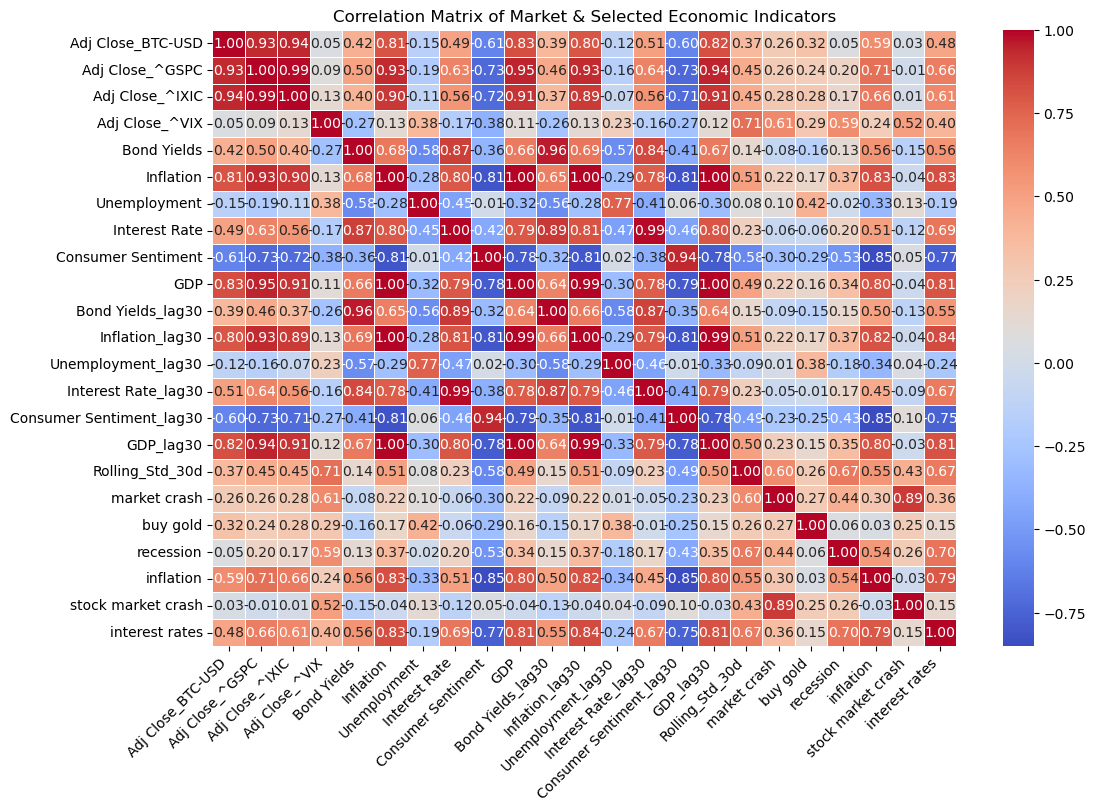

In [26]:
# Dynamically find available features
available_features = [col for col in selected_features if col in full_data.columns]

# Check if any features are missing
missing_features = [col for col in selected_features if col not in full_data.columns]

if missing_features:
    print(f"Warning: The following features are missing from full_data: {missing_features}")

# Filter dataset with only available features
viz_data = full_data[available_features].dropna()

# Compute correlation matrix
corr_matrix = viz_data.corr()

# Plot improved heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Market & Selected Economic Indicators")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

## **VII. Save the Dataset**

We save this as a parquet file because it could be pretty overwhelming as a CSV.

In [93]:
# # Save the cleaned dataset for Notebook 1
# file_path = "financial_data_cleaned.parquet"
# full_data.to_parquet(file_path)
# print(f"Cleaned dataset saved as {file_path}")

Cleaned dataset saved as financial_data_cleaned.parquet


In [27]:
# Define the directory path for saving
save_dir = "Param_IndianMutualFunds/A0_DataAggregation/Working Folder/data"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Define the full file path
file_path = os.path.join(save_dir, "financial_data_cleaned.parquet")

# Save the cleaned dataset
full_data.to_parquet(file_path)

print(f"✅ Cleaned dataset saved at: {file_path}")

✅ Cleaned dataset saved at: Param_IndianMutualFunds/A0_DataAggregation/Working Folder/data/financial_data_cleaned.parquet


### **📊Next Steps**
Now that we have a cleaned dataset:
- Move to **Notebook 1** for feature engineering and shock modeling.
- Define financial shock detection methods based on the collected data.
- Explore multiple methods to classify shocks in the market.


In [28]:
full_data.columns

Index(['Adj Close_BTC-USD', 'Adj Close_^GSPC', 'Adj Close_^IXIC',
       'Adj Close_^VIX', 'Bond Yields', 'Inflation', 'Unemployment',
       'Interest Rate', 'Consumer Sentiment', 'GDP',
       ...
       'Interest Rate_lag30_lag90_lag180_rolling90_rolling180',
       'Consumer Sentiment_lag30_lag90_lag180_rolling90_rolling180',
       'GDP_lag30_lag90_lag180_rolling90_rolling180', 'Rolling_Std_30d',
       'market crash', 'buy gold', 'recession', 'inflation',
       'stock market crash', 'interest rates'],
      dtype='object', length=203)

In [29]:
full_data.head()

,Adj Close_BTC-USD,Adj Close_^GSPC,Adj Close_^IXIC,Adj Close_^VIX,Bond Yields,Inflation,Unemployment,Interest Rate,Consumer Sentiment,GDP,...,Interest Rate_lag30_lag90_lag180_rolling90_rolling180,Consumer Sentiment_lag30_lag90_lag180_rolling90_rolling180,GDP_lag30_lag90_lag180_rolling90_rolling180,Rolling_Std_30d,market crash,buy gold,recession,inflation,stock market crash,interest rates
2000-01-01,NaN,NaN,NaN,NaN,NaN,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,NaN,1455.219971,4131.149902,24.209999,6.58,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,1399.420044,3901.689941,27.010000,6.49,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,1402.109985,3877.540039,26.410000,6.62,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,1403.449951,3727.129883,25.730000,6.57,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
full_dataTest.head()

,Adj Close_BTC-USD,Adj Close_^GSPC,Adj Close_^IXIC,Adj Close_^VIX,Bond Yields,Inflation,Unemployment,Interest Rate,Consumer Sentiment,GDP,...,Interest Rate_lag30_lag90_lag180_rolling90_rolling180,Consumer Sentiment_lag30_lag90_lag180_rolling90_rolling180,GDP_lag30_lag90_lag180_rolling90_rolling180,Rolling_Std_30d,market crash,buy gold,recession,inflation,stock market crash,interest rates
2000-01-01,NaN,NaN,NaN,NaN,NaN,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,NaN,1455.219971,4131.149902,24.209999,6.58,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,1399.420044,3901.689941,27.010000,6.49,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,1402.109985,3877.540039,26.410000,6.62,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,1403.449951,3727.129883,25.730000,6.57,169.3,4.0,5.45,112.0,10002.179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
